In [31]:
import random
import networkx as nx
from matplotlib import pyplot as plt
from collections import Counter
import math
from utils.plotTools import plot_qwak
import os
import ast
import numpy as np
import json
import pandas as pd
from sklearn.linear_model import LinearRegression

from scripts import load_list_from_file, write_list_to_file, load_or_generate_data, draw_graph, draw_graph_from_adjacency_matrix
from scripts_tempHelix import generate_static_temporal_helix, generate_temporal_helix, multiple_exponential_temporal_helix
from scripts_theoreticalHittingTime import create_transition_matrix

In [2]:
def print_matrix(matrix):
    # Print rows with left and right border
    for row in matrix:
        print('|', end='')
        print(' '.join(format(item, ".2f") for item in row), end=' |\n')
        
figsize = (15, 6)
k = 0.2
draw_self_loops = False

config = {
    'figsize': figsize,
    'k': k,
    'draw_self_loops': draw_self_loops,
    'node_color': 'orange',
    'node_size': 800,
    'normal_edge_color': 'blue',
    'normal_edge_width': 1.5,
    'edge_style': 'solid',
    'self_loop_color': 'red',
    'title': 'H_2_0'
}

config1 = {
    'figsize': figsize,
    'k': k,
    'draw_self_loops': draw_self_loops,
    'node_color': 'orange',
    'node_size': 800,
    'normal_edge_color': 'blue',
    'normal_edge_width': 1.5,
    'edge_style': 'solid',
    'self_loop_color': 'red',
    'title': 'H_2_1'
}

config2 = {
    'figsize': figsize,
    'k': k,
    'draw_self_loops': draw_self_loops,
    'node_color': 'orange',
    'node_size': 800,
    'normal_edge_color': 'blue',
    'normal_edge_width': 1.5,
    'edge_style': 'solid',
    'self_loop_color': 'red',
    'title': 'H_2_2'
}

config3 = {
    'figsize': figsize,
    'k': k,
    'draw_self_loops': draw_self_loops,
    'node_color': 'orange',
    'node_size': 800,
    'normal_edge_color': 'blue',
    'normal_edge_width': 1.5,
    'edge_style': 'solid',
    'self_loop_color': 'red',
    'title': 'H_2_3'
}

# New graph every step

In [95]:
def estimate_hitting_time(reps, start_vertex, end_vertex, num_simulations=10):
    """
    Estimate the hitting time between two vertices in a list of lollipop graphs.

    Parameters:
    m_values (list): The list of m values, each representing the number of vertices in the complete graph part of a lollipop graph.
    n_values (list): The list of n values, each representing the number of vertices in the path part of a lollipop graph.
    start_vertex (int): The starting vertex for the random walk.
    end_vertex (int): The target vertex for the random walk.
    num_simulations (int): The number of simulations to perform.

    Returns:
    hitting_times (list): A list of estimated average hitting times for each lollipop graph.
    """

    hitting_times = []

    for rep in range(1,reps+1):
        print(f'\nCalculatig hitting time for reps = {rep} ; n = {3+3*rep}')
        total_steps_for_all_simulations = 0

        # Create the lollipop graph
        graph = nx.from_numpy_array(generate_temporal_helix(rep,0))
        current_node = list(graph.nodes)[start_vertex]
        end_node = list(graph.nodes)[end_vertex]
        print(f'Starting node: {current_node} \t Neighbors: {list(nx.neighbors(graph,current_node))}')
        print(f'End node: {end_node} \t Neighbors: {list(nx.neighbors(graph,end_node))}')
        for s in range(num_simulations):
            if s == 0 or s == 1 or s % 5 == 0:
                print(f'----> Sample number:{s}')
                pass
            total_steps_this_simulation = 0
            current_node = list(graph.nodes)[start_vertex]
            # Loop continues until end_vertex is reached
            while current_node != end_node:
                # Choose a neighbor randomly
                graph = nx.from_numpy_array(generate_temporal_helix(rep,total_steps_this_simulation))
                neighbors = list(nx.neighbors(graph, current_node))
                if neighbors:
                    current_node = random.choice(neighbors)
                total_steps_this_simulation += 1
                # print(current_node)
                # print(end_node)
                # print()

            # Accumulate the total steps for this simulation
            total_steps_for_all_simulations += total_steps_this_simulation

        # Average the total steps over the number of simulations
        average_hitting_time = total_steps_for_all_simulations / num_simulations
        hitting_times.append(average_hitting_time)

    return hitting_times

def theoretical_hitting_time(reps,epsilon,factor):
    cover_times = []
    k = 0
    for n in range(1,reps+1):
        k = n**epsilon
        cover_times.append(2**(factor*k))
    return cover_times
       
    return hitting_times

In [96]:
epsilon = 0.50

reps = 8
nrange2 = [3 + 3*rep for rep in range(1,reps)]
nrange3 = [3 + 3*rep for rep in range(1,reps+1)]
factor = 4.5

fromNode = 0
toNode = -1


samples = 20


hitting_times_file = f'Datasets/DynGraphsDTRW/hittingTimeV2TemporalHelix_N{nrange2[0]}-{nrange2[-1]}_EPS{epsilon}_S{samples}.txt'

if os.path.exists(hitting_times_file):
    hitting_times = load_list_from_file(hitting_times_file)
    estimate_hitting_time_memory = [x for x in theoretical_hitting_time(reps,epsilon,factor)]
    print('File exists!')
else:
    print('File Doesnt Exist!')
    hitting_times = estimate_hitting_time(reps,fromNode,toNode, num_simulations=samples)
    write_list_to_file(hitting_times_file, hitting_times)
    estimate_hitting_time_memory = [x for x in theoretical_hitting_time(reps,epsilon,factor)]

File exists!


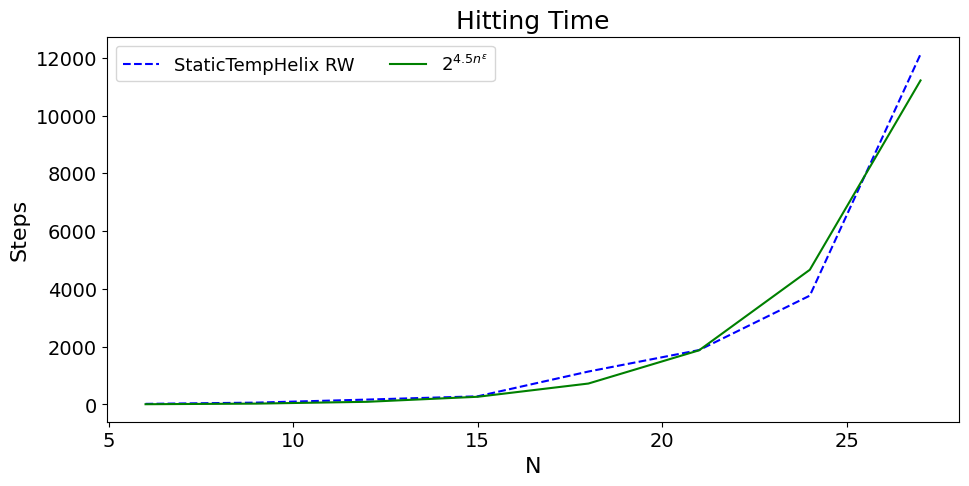

In [106]:
alphaLabelList = [r'StaticTempHelix RW',r'$2^{' +f'{factor}' +r'n^\epsilon}$']

params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252'],
    'line_style_list' : ['--', '-','-.' ],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    # 'x_num_ticks' : 7,
    # 'y_num_ticks' : 7,
    # 'x_round_val' : 1,
    # 'y_round_val' : 3,
}

plot_qwak(x_value_matrix = [list(nrange3),list(nrange3)] , y_value_matrix = [hitting_times,estimate_hitting_time_memory],**params)

## Fitting the model

In [103]:
nrange3 = [3 + 3*rep for rep in range(1,reps+1)]
# Use the modified function to generate the DataFrame
print(nrange3)
for i in range(1,reps+1):
    graph = nx.from_numpy_array(generate_temporal_helix(i,0))
    print(len(graph))

df = pd.DataFrame({
    'n': nrange3,
    'hitting_times': hitting_times
})

# Calculate the log-log values
df['log_n'] = np.log2(df['n'])
df['log_log_hitting_times'] = np.log2(np.log2(df['hitting_times']))

# Reshape data for sklearn
X = df['log_n'].values.reshape(-1,1)
Y = df['log_log_hitting_times'].values.reshape(-1,1)

# Create a linear regression model
model = LinearRegression()

# Fit the model
model.fit(X, Y)

# The coefficient in the model is the estimate of epsilon, and 2^intercept is the estimate of c
epsilon = model.coef_[0][0]
c = 2**model.intercept_[0]

print('c =', c)
print('epsilon =', epsilon)


[6, 9, 12, 15, 18, 21, 24, 27]
6
9
12
15
18
21
24
27
c = 1.1536703104816697
epsilon = 0.740576942962586


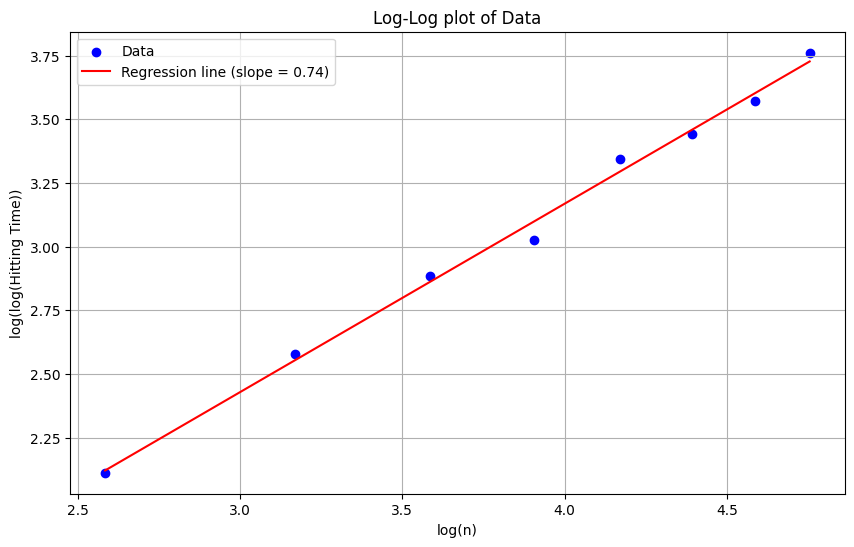

In [83]:
def plot_loglog(x_data, y_data):
    # Take the logarithm of your data
    log_x = np.log2(x_data)
    log_y = np.log2(np.log2(y_data))

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.scatter(log_x, log_y, color='blue', label='Data')

    # Add a regression line
    slope, intercept = np.polyfit(log_x, log_y, 1)
    plt.plot(log_x, slope*log_x + intercept, color='red', label=f'Regression line (slope = {slope:.2f})')

    # Add labels and legend
    plt.xlabel('log(n)')
    plt.ylabel('log(log(Hitting Time))')
    plt.title('Log-Log plot of Data')
    plt.legend()
    plt.grid(True)
    plt.show()

x_data = nrange3
y_data = hitting_times
# Assume x_data and y_data are your data
plot_loglog(x_data, y_data)

[7.3828394025828405, 28.22706970357434, 90.93659125508294, 265.3603772730611, 723.4100710787582, 1873.900525685987, 4661.505053534716, 11216.35352378165]


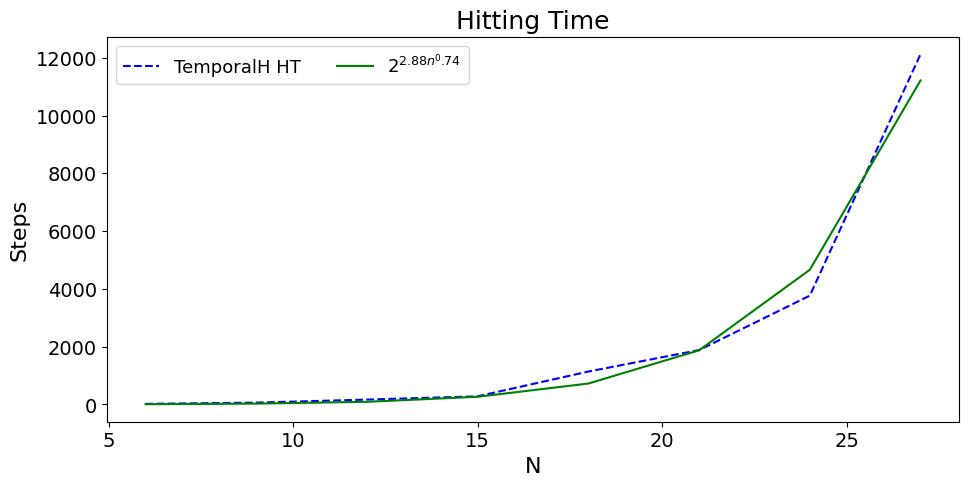

In [105]:
c = 2.5*1.1536703104816697
epsilon = 0.740576942962586

estimate_hitting_time_memory = [x for x in theoretical_hitting_time(reps,epsilon,c)]
print(estimate_hitting_time_memory)

alphaLabelList = [r'TemporalH HT', '$2^{' + f'{round(c,2)}' + r'n^' + f'{round(epsilon,2)}' + r'}$']

params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252'],
    'line_style_list' : ['--', '-','-.' ],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    # 'x_num_ticks' : 7,
    # 'y_num_ticks' : 7,
    # 'x_round_val' : 1,
    # 'y_round_val' : 3,
}

plot_qwak(x_value_matrix = [list(nrange3),list(nrange3)] , y_value_matrix = [hitting_times,estimate_hitting_time_memory],**params)

## Theoretical hitting time

In [23]:
def expected_hitting_time(P1,P2,P3, q, z):
    """
    Calculate the expected hitting time to state z.

    Parameters:
    P (numpy.ndarray): Transition matrix.
    q (numpy.ndarray): Initial state distribution.
    z (int): Target state.

    Returns:
    float: Expected hitting time to state z from state q.
    """
    
    n = P1.shape[0]  # Number of states

    P1_minus_z, P2_minus_z, P3_minus_z = [P.copy() for P in [P1, P2, P3]]
    q_minus_z = q.copy()
    
    # Zeroing the row and column corresponding to z
    for P_minus_z in [P1_minus_z, P2_minus_z, P3_minus_z]:
        P_minus_z[z, :] = 0
        P_minus_z[:, z] = 0
        
    # Create the modified initial state distribution q_{-z}
    q_minus_z = q.copy()
    q_minus_z[z] = 0  # zero the element corresponding to z

    # Create the identity matrix
    I = np.eye(n)
    
    P_Dyn1 = np.dot(P2_minus_z,P1_minus_z) + P1_minus_z + I
    P_Dyn2 = np.linalg.inv(I - np.matmul(P3_minus_z,np.matmul(P2_minus_z,P1_minus_z)))
    
    P_Dyn = np.matmul(P_Dyn1,P_Dyn2)

    # Calculate the inverse of (I - P_{-z})
    # inv = np.linalg.inv(I - P_Dyn)

    # Calculate the expected hitting time from state q to state z
    h_z_q = np.dot(q_minus_z, np.dot(P_Dyn, np.ones(n)))

    return h_z_q

def hitting_times_for_tempHelix_graphs(reps, initIndex, target):
    hitting_times = []
    for rep in range(1,reps+1):
            G1 = nx.from_numpy_array(generate_temporal_helix(rep,0))
            G2 = nx.from_numpy_array(generate_temporal_helix(rep,1))
            G3 = nx.from_numpy_array(generate_temporal_helix(rep,2))
            init = np.zeros(len(G1))
            init[initIndex] = 1
            P1 = create_transition_matrix(G1)
            P2= create_transition_matrix(G2)
            P3 = create_transition_matrix(G3)
            hitting_time = expected_hitting_time(P1,P2,P3, init, target)
            hitting_times.append(hitting_time)
    return hitting_times

def is_convergent(A):
    # Check if A is a square matrix
    if A.shape[0] != A.shape[1]:
        return False, "Matrix must be square."
    # Compute the eigenvalues of A
    eigenvalues = np.linalg.eigvals(A)
    # Compute the spectral radius (maximum absolute value of eigenvalues)
    spectral_radius = max(abs(eigenvalues))
    # Check if the spectral radius is less than 1
    if spectral_radius < 1:
        return True
    else:
        return False
    
def is_singular(matrix, tol=1e-9):
    return abs(np.linalg.det(matrix)) < tol


def is_invertible(matrix, tol=1e-9):
    return not np.isclose(np.linalg.det(matrix), 0, atol=tol)

reps = 8

init = 0
target = -1

theoretical_hitting_times = hitting_times_for_tempHelix_graphs(reps, init, target)
print(theoretical_hitting_times)

[36.00000000000001, 115.9999999999998, 325.99999999999955, 860.9999999999955, 2208.499999999942, 5587.249999999593, 14044.124999997446, 35196.312499984124]


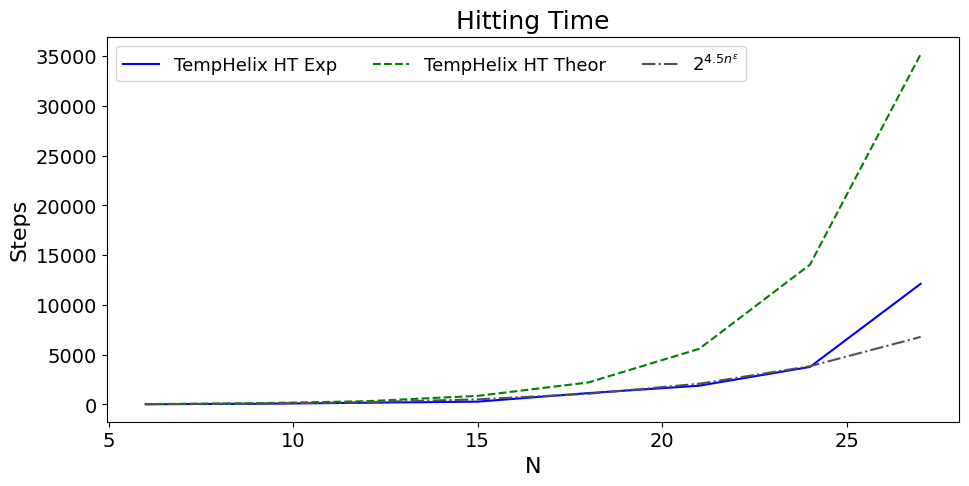

In [29]:
epsilon = 0.50

reps = 8
factor = 4.5
alphaLabelList = [r'TempHelix HT Exp',f'TempHelix HT Theor',r'$2^{' +f'{factor}' +r'n^\epsilon}$']

estimate_hitting_time_memory = [x for x in theoretical_hitting_time(reps,epsilon,factor)]


params = {
    'font_size' : 14,
    'figsize': (11, 5),
    'plot_title' : f'Hitting Time',
    'x_label' : 'N',
    'y_label' : "Steps",
    'legend_labels' : alphaLabelList,
    'legend_loc': "best",
    # 'legend_title' : r'$\alpha$',
    'legend_ncol' : 3,
    'color_list' : ['#0000FF', '#008000', '#525252','#eb4034'],
    'line_style_list' : ['-', '--','-.',':' ],
    # 'save_path' : f'Output/OrientedDynamics/orientedDynamics_N{N}_NWALKS{len(alphaList)}_Alphas{str([round(a, 2) for a in alphaList]).replace(", ", "-").replace("[", "").replace("]", "")}_TMAX{round(t)}.png',
    'use_loglog': False,
    'use_cbar' : False,
    'cbar_label' : None, 
    'cbar_ticks' : None,
    'cbar_tick_labels' : None,
    'x_lim' : None,
    # 'x_num_ticks' : 7,
    # 'y_num_ticks' : 7,
    # 'x_round_val' : 1,
    # 'y_round_val' : 3,
}

plot_qwak(x_value_matrix = [list(nrange3)]*3 , y_value_matrix = [hitting_times,theoretical_hitting_times,estimate_hitting_time_memory],**params)

In [21]:
rep = 1
initIndex = 0
z = -1

G1 = nx.from_numpy_array(generate_temporal_helix(rep,0))
# draw_graph(G1, config=config1)

G2 = nx.from_numpy_array(generate_temporal_helix(rep,1))
# draw_graph(G2, config=config2)

G3 = nx.from_numpy_array(generate_temporal_helix(rep,2))
# draw_graph(G3, config=config3)

n = len(G1)
q = np.zeros(n)
q[initIndex] = 1
I = np.eye(n)

P1 = create_transition_matrix(G1)
P2= create_transition_matrix(G2)
P3 = create_transition_matrix(G3)

P1_minus_z, P2_minus_z, P3_minus_z, I_minus_z = [P.copy() for P in [P1, P2, P3, I]]
    
for P_minus_z in [P1_minus_z, P2_minus_z, P3_minus_z,I_minus_z]:
    P_minus_z[z, :] = 0
    P_minus_z[:, z] = 0

q_minus_z = q.copy()
q_minus_z[z] = 0

print()
print(f'P1\t is_invertible = {is_invertible(P1_minus_z)}')
print_matrix(P1_minus_z)
print()
print(f'P2\t is_invertible = {is_invertible(P2_minus_z)}')
print_matrix(P2_minus_z)
print()
print(f'P3\t is_invertible = {is_invertible(P3_minus_z)}')
print_matrix(P3_minus_z)
print()
# print('I-z')
# print_matrix(I_minus_z)
# print()

P_Dyn1 = np.matmul(P2_minus_z,P1_minus_z) + P1_minus_z + I
print('PDYN1')
print_matrix(P_Dyn1)
print()

P_Dyn2_sub1 = np.matmul(P3_minus_z , np.matmul(P2_minus_z ,P1_minus_z))
print(f'PDYN2_sub1\t is_invertible = {is_invertible(P_Dyn2_sub1)}\t is_convergent={is_convergent(P_Dyn2_sub1)}')
print_matrix(P_Dyn2_sub1)
print()

P_Dyn2_sub2 = I - P_Dyn2_sub1
print(f'PDYN2_sub2\t is_invertible = {is_invertible(P_Dyn2_sub1)}')
print_matrix(P_Dyn2_sub2)
print()

P_Dyn2 = np.linalg.inv(P_Dyn2_sub2)
print('PDYN2')
print_matrix(P_Dyn2)
print()

P_Dyn = np.matmul(P_Dyn1,P_Dyn2)

print('PDYN = PDYN1 * PDYN2')
print_matrix(P_Dyn)
print()

# print('I - PDYN')
# id_PDyn = I - P_Dyn
# print_matrix(id_PDyn)

# print('I - PDYN inv')
# inv = np.linalg.inv(id_PDyn)
# print()
# print_matrix(inv)


h_z_q = np.dot(q_minus_z, np.dot(P_Dyn, np.ones(n)))
print()
print(h_z_q)


P1	 is_invertible = False
|0.50 0.50 0.00 0.00 0.00 0.00 |
|0.17 0.50 0.17 0.17 0.00 0.00 |
|0.00 0.25 0.50 0.00 0.25 0.00 |
|0.00 0.25 0.00 0.50 0.25 0.00 |
|0.00 0.00 0.17 0.17 0.50 0.00 |
|0.00 0.00 0.00 0.00 0.00 0.00 |

P2	 is_invertible = False
|0.50 0.50 0.00 0.00 0.00 0.00 |
|0.17 0.50 0.17 0.00 0.17 0.00 |
|0.00 0.25 0.50 0.25 0.00 0.00 |
|0.00 0.00 0.17 0.50 0.17 0.00 |
|0.00 0.25 0.00 0.25 0.50 0.00 |
|0.00 0.00 0.00 0.00 0.00 0.00 |

P3	 is_invertible = False
|0.50 0.50 0.00 0.00 0.00 0.00 |
|0.17 0.50 0.00 0.17 0.17 0.00 |
|0.00 0.00 0.50 0.17 0.17 0.00 |
|0.00 0.25 0.25 0.50 0.00 0.00 |
|0.00 0.25 0.25 0.00 0.50 0.00 |
|0.00 0.00 0.00 0.00 0.00 0.00 |

PDYN1
|1.83 1.00 0.08 0.08 0.00 0.00 |
|0.33 1.88 0.36 0.28 0.12 0.00 |
|0.04 0.56 1.79 0.17 0.44 0.00 |
|0.00 0.42 0.11 1.78 0.50 0.00 |
|0.04 0.19 0.29 0.42 1.81 0.00 |
|0.00 0.00 0.00 0.00 0.00 1.00 |

PDYN2_sub1	 is_invertible = False	 is_convergent=True
|0.25 0.44 0.14 0.10 0.06 0.00 |
|0.15 0.33 0.15 0.16 0.16 0.00 |